In [151]:
import qiskit
import qiskit_machine_learning as qml
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA, SNOBFIT
from qiskit.circuit import Parameter, ParameterExpression, ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels.parameterized_quantum_kernel import ParamQuantumKernel
from qiskit_machine_learning.kernels import QuantumKernel

from qiskit_machine_learning.algorithms import QSVC


from qiskit import QuantumCircuit, Aer
from qiskit.aqua import QuantumInstance

import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial,reduce
import numpy as np
import copy
from copy import deepcopy as dc

# Generate a trivial dataset

In [152]:
x_vec = [[ 0,  2],
         [.1, .4],
         [.5, .3],
         [.8, .2]]
y = [1, 1, -1, -1]

### Define the objective function used to train the PQK

In [153]:
def std_align(params, PQK=None, x_vec=None, y=None):
    assert PQK is not None
    assert x_vec is not None
    assert y is not None
    
    # check that params are the right dimension
    PQK.bind_free_params(params)
    K = PQK.evaluate(x_vec)
    y = np.array(y)
    
    # The -1 is here because qiskit 
    # optimizers minimize by default
    return -1 * y.T @ K @ y

def weighted_align(params, 
                   PQK=None, 
                   x_vec=None, 
                   y=None):
    assert PQK is not None
    assert x_vec is not None
    assert y is not None
    
    # check that params are the right dimension
    PQK.bind_free_params(params)
    
    qsvc = QSVC(quantum_kernel = PQK)
    qsvc.fit(x_vec, y)
    score = qsvc.score(x_vec, y)
    
    # The dual coefficients are equal
    # to the Lagrange multipliers, termwise
    # multiplied by the corresponding datapoint's 
    # label. 
    a = qsvc.dual_coef_[0]
    
    K = PQK.evaluate(x_vec)

    # The -1 is here because qiskit 
    # optimizers minimize by default
    return -1 * a.T @ K @ a

### Instantiate and train the PQK

In [148]:
#cb_results_hist = []

In [ ]:

# Define my feature map, partition my parameters
n_qubits = 4
fm = ZZFeatureMap(n_qubits, reps=2)
input_params = fm.parameters[::2]
free_params = fm.parameters[1::2]

# instantiate a simulator backend
qi = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))

# Define my parameterized Kernel
pqk = ParamQuantumKernel(fm, free_params, input_params, quantum_instance=qi)

# Bind neccesary inputs to objective_function, such that it
# has `f(free_param_values) = real-scalar` usage.
#alignment = partial(std_align, PQK=pqk, x_vec=x_vec, y=y)
alignment = partial(weighted_align, PQK=pqk, x_vec=x_vec, y=y)


cb_results = [[],[],[],[],[]]
def callback(x0,x1=None,x2=None,x3=None,x4=None):
    cb_results[0].append(x0)
    cb_results[1].append(x1)
    cb_results[2].append(x2)
    cb_results[3].append(x3)
    cb_results[4].append(x4)
    
# instantiate an optimizer
optimizer = SPSA(maxiter = 2500, callback=callback)
#optimizer = SLSQP(maxiter = 10, callback=callback)
cb_results_hist.append(cb_results)

# do kernel alignment
results = pqk.train_kernel(objective_function=alignment, 
                           optimizer=optimizer)

results.__dict__

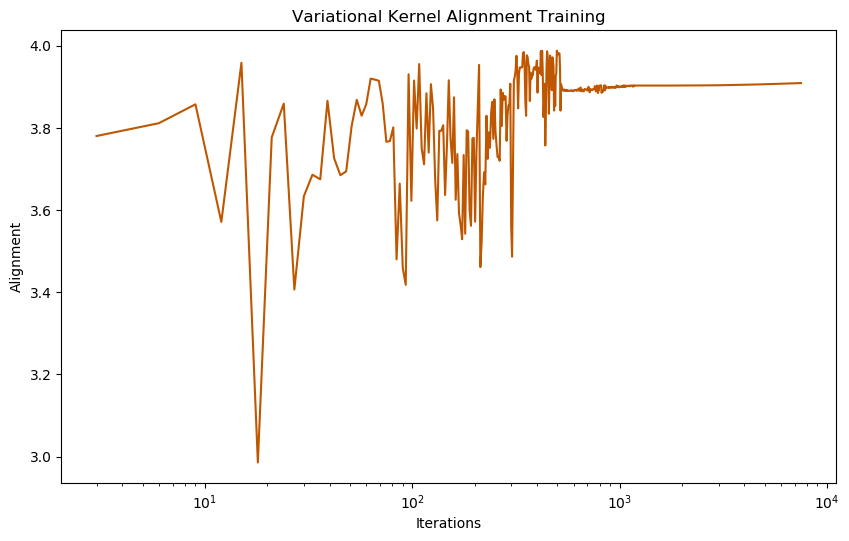

In [191]:
results = cb_results_hist[-1]
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 100
plt.plot(results[0][:2500], -1*np.array(results[2][:2500]), color='#bf5700')
plt.xlabel('Iterations')
plt.ylabel('Alignment')
plt.title("Variational Kernel Alignment Training")
plt.xscale('log')


# Below is the actual kernel matrix we learned
### Note that the data is sorted by class, so theoretically optimal kernel would be block diagonal: 

$K_{ideal}$ = ```[[1, 1, 0, 0]
        [1, 1, 0, 0]
        [0, 0, 1, 1]
        [0, 0, 1, 1]]```

In [193]:
pqk.evaluate(x_vec)

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


array([[1.        , 0.22761922, 0.00728738, 0.08104012],
       [0.22761922, 1.        , 0.0109997 , 0.00965488],
       [0.00728738, 0.0109997 , 1.        , 0.00855295],
       [0.08104012, 0.00965488, 0.00855295, 1.        ]])

In [194]:
qsvc.dual_coef_

array([[-0.90661066, -0.92047696,  0.90598988,  0.92109774]])

# After out PQK has been trained, it can immediately be used as a standard kernel.
### This is possible because the optimal free parameters are automatically bound to the feature map. 
If the user desires, they are also free to set the free parameters to whatever values they wish. 

In [104]:
qsvc = QSVC(quantum_kernel = pqk)
qsvc.fit(x_vec, y)
score = qsvc.score(x_vec, y)
print("Training accuracy = ", score)

/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)


Training accuracy =  1.0


/Users/brycefuller/anaconda3/lib/python3.7/site-packages/qiskit/providers/aer/aerjob.py:56: DeprecationWarning: The BaseJob abstract interface is deprecated as of the 0.18.0 release and will be removed in a future release. Instead you should build your backends using the JobV1 abstract class (which is the current latest version of the backend interface)
  super().__init__(backend, job_id)
